[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PennNGG/Quantitative-Neuroscience/blob/master/Concepts/Python/Multiple%20Comparisons.ipynb)

# Definitions

The multiple comparisons problem in statistics occurs when multiple statistical inferences are done simultaneously, which greatly increases the probability that any one inference will yield an erroneous result, by chance. A lot has been written about this problem, including:

- [Its prevalence in fMRI data analysis](https://www.sciencedirect.com/science/article/pii/S1053811912007057?via%3Dihub) (including a compelling illustration by this [prizewinning study](https://blogs.scientificamerican.com/scicurious-brain/ignobel-prize-in-neuroscience-the-dead-salmon-study/)\)

- [How Baysian methods can avoid the problem](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf).

- [General approaches for correcting for multiple comparisons](http://www.biostathandbook.com/multiplecomparisons.html).

Here we will provide some intuition for the problem using a simple thought experiment, to sensitize you to how much of a problem it can be. Consider performing the same statistical test on *N* different samples corresponding to, say, different voxels in fMRI data, using a *p*-value of $\alpha$ (typically 0.05) for each test. 

Thus, for any one test, the probability of getting a Type I error (rejecting $H_0$ when $H_0$ is true) is $\alpha$:

$p_{error}=\alpha$

For two tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from either one:

$p_{error}=1-(1-\alpha)(1-\alpha)$

For *N* tests, the probably of getting a Type I error for either test is just one minus the combined probability of not getting a Type I error from any one:

$p_{error}=1-(1-\alpha)^N$

Run the cell below to see that the probability of getting a Type I error under these conditions grows rapidly with *N*, implying that it becomes very, very likely that you will get a "statistically significant result" just by chance if you do enough tests:

Text(0, 0.5, '$P_{error}$')

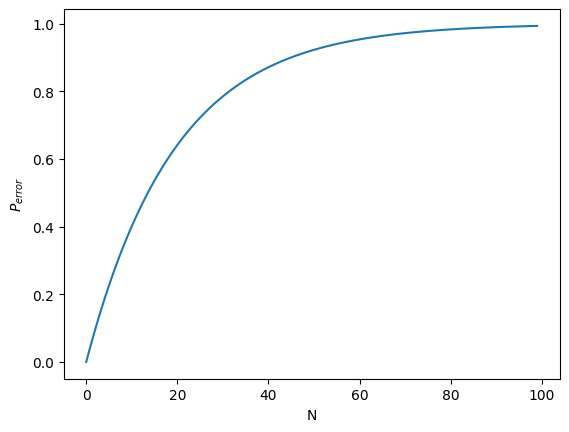

In [1]:
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.05
N = np.arange(0,100)
plt.plot(N, 1-(1-alpha)**N)
plt.xlabel('N')
plt.ylabel('$P_{error}$')

# Correcting for multiple comparisons



There are a number of different methods that can be used to [correct for this problem](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5506159/). Below are two common methods.




## Bonferroni correction

The simplest way to correct for Type I errors (false positives) in multiple comparisons is to divide $\alpha$ by the number of comparisons, known as the [Bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html). This is a very conservative test that is typically used when the number of comparisons is relatively small and you want to avoid Type I errors.

## Benjamini–Hochberg procedure


Another approach is to more carefully control the false-discovery rate using the [Benjamini–Hochberg procedure](https://www.jstor.org/stable/2346101?seq=1#metadata_info_tab_contents):

1\. Rank the individual *p*-values in ascending order, labeled *i*=1...*n*

2\. For each *p*-value, calculate its "critical value" as (*i*/*n*)*Q*, where *i* is the rank, *n* is the total number of tests, and *Q* is the false discovery rate (a percentage) that you choose (typically 0.05).

3\. In your rank-ordered, original *p*-values, find the largest value that is smaller than its associated critical value; this *p*-value is the new criterion (i.e., reject $H_0$ for all cases for which *p* ≤ this value).

# Exercise

In this exercise we will run through an example of correcting for multiple comparisons with both the Benjamini-Hochberg procedure and the more conservative Bonferroni correction. 

First, simulate multiple (say, 1000) t-tests comparing two samples with equal means and standard deviations, and save the p-values. Obviously, at p<0.05 we expect that ~5% of the simulations to yield a "statistically significant" result (of rejecting the NULL hypothesis that the samples come from distributions with equal means).

Second, once you have the simulated p-values, apply both methods to address the multiple comparisons problem.

Third, set the sample 1 and sample 2 means to be 1 and 2 respectively, and re-run the exercise. What do you notice? What if you make the difference between means even greater?

## Part 1: Simulating Multiple T-tests

In [2]:
# Block 1 — simulate null t-tests and save p-values
import numpy as np
from scipy import stats

rng = np.random.default_rng(123)
n_tests = 1000
n_per_group = 30
mu1 = mu2 = 0.0
sigma = 1.0

pvals_null = np.empty(n_tests)
for i in range(n_tests):
    x = rng.normal(mu1, sigma, n_per_group)
    y = rng.normal(mu2, sigma, n_per_group)
    t, p = stats.ttest_ind(x, y, equal_var=False)  # Welch t-test
    pvals_null[i] = p

alpha = 0.05
print(f"Uncorrected: {np.sum(pvals_null < alpha)}/{n_tests} significant "
      f"({np.mean(pvals_null < alpha):.3f})")


Uncorrected: 46/1000 significant (0.046)


## Part 2: Applying both methods to address the multiple comparisons problem.

In [3]:
# Block 2 — apply Bonferroni and BH (FDR) to the null p-values
import numpy as np

def benjamini_hochberg(pvals, q=0.05):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    crit = (np.arange(1, n + 1) / n) * q
    below = ranked <= crit
    if not np.any(below):
        thresh = 0.0
        reject_ordered = np.zeros(n, dtype=bool)
    else:
        k = np.max(np.where(below)[0])
        thresh = ranked[k]
        reject_ordered = ranked <= thresh
    reject = np.zeros(n, dtype=bool)
    reject[order] = reject_ordered
    return reject, float(thresh)

alpha = 0.05
N = len(pvals_null)

# Bonferroni
bonf_thresh = alpha / N
bonf_reject = pvals_null <= bonf_thresh

# BH
bh_reject, bh_thresh = benjamini_hochberg(pvals_null, q=0.05)

print(f"Bonferroni: threshold={bonf_thresh:.6f}, rejections={bonf_reject.sum()}/{N}")
print(f"BH (q=0.05): threshold={bh_thresh:.6f}, rejections={bh_reject.sum()}/{N}")


Bonferroni: threshold=0.000050, rejections=0/1000
BH (q=0.05): threshold=0.000000, rejections=0/1000


## Part 3: Setting the sample 1 and sample 2 means to be 1 and 2 

In [1]:
# Block 3 — rerun with true mean differences and compare power vs corrections
import numpy as np
from scipy import stats

rng = np.random.default_rng(456)
alpha = 0.05
n_tests = 1000
n_per_group = 30

def simulate_pvals(mu1, mu2, sigma=1.0, n_tests=1000, n_per_group=30, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    pvals = np.empty(n_tests)
    for i in range(n_tests):
        x = rng.normal(mu1, sigma, n_per_group)
        y = rng.normal(mu2, sigma, n_per_group)
        t, p = stats.ttest_ind(x, y, equal_var=False)
        pvals[i] = p
    return pvals

def benjamini_hochberg(pvals, q=0.05):
    p = np.asarray(pvals, dtype=float)
    n = p.size
    order = np.argsort(p)
    ranked = p[order]
    crit = (np.arange(1, n + 1) / n) * q
    below = ranked <= crit
    if not np.any(below):
        thresh = 0.0
        reject_ordered = np.zeros(n, dtype=bool)
    else:
        k = np.max(np.where(below)[0])
        thresh = ranked[k]
        reject_ordered = ranked <= thresh
    reject = np.zeros(n, dtype=bool)
    reject[order] = reject_ordered
    return reject, float(thresh)

def summarize(mu1, mu2, label):
    p = simulate_pvals(mu1, mu2, n_tests=n_tests, n_per_group=n_per_group, rng=rng)
    uncorrected = np.sum(p < alpha)
    bonf = np.sum(p <= alpha / len(p))
    bh_reject, bh_thresh = benjamini_hochberg(p, q=0.05)
    print(f"{label} (μ1={mu1}, μ2={mu2})")
    print(f"  Uncorrected: {uncorrected}/{n_tests} ({uncorrected/n_tests:.3f})")
    print(f"  Bonferroni:  {bonf}/{n_tests}")
    print(f"  BH (q=0.05): {bh_reject.sum()}/{n_tests} (threshold={bh_thresh:.6f})")

summarize(1.0, 2.0, "Moderate effect Δ=1")
summarize(0.0, 2.0, "Larger effect Δ=2")
summarize(0.0, 3.0, "Very large effect Δ=3")


Moderate effect Δ=1 (μ1=1.0, μ2=2.0)
  Uncorrected: 975/1000 (0.975)
  Bonferroni:  341/1000
  BH (q=0.05): 974/1000 (threshold=0.048173)
Larger effect Δ=2 (μ1=0.0, μ2=2.0)
  Uncorrected: 1000/1000 (1.000)
  Bonferroni:  999/1000
  BH (q=0.05): 1000/1000 (threshold=0.000078)
Very large effect Δ=3 (μ1=0.0, μ2=3.0)
  Uncorrected: 1000/1000 (1.000)
  Bonferroni:  1000/1000
  BH (q=0.05): 1000/1000 (threshold=0.000000)


# Under the null (no true effect), ~5% of tests are “significant” uncorrected, but Bonferroni and BH typically yield 0 rejections—illustrating how they suppress false positives across many tests. With a true effect (Δ=1), BH retains high power (rejects most tests), while Bonferroni is more conservative (fewer rejections). As we increase the effect size (Δ=2, Δ=3), all methods rapidly approach ~100% rejections—the signal overwhelms the correction

# Additional Resources


How to correct for multiple comparisons in [Matlab](https://www.mathworks.com/help/stats/multcompare.html), [R](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/p.adjust.html), and [Python](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html)

# Credits

Copyright 2021 by Joshua I. Gold, University of Pennsylvania